# 4 Assets - 7 Day Rebalancing Simulation

This notebook simulates the rebalancing algorithim with 20 years of data. The parameters choosen here are 

- 7 day intereval for every rebalance
- (Default) 5% slippage during every rebalance
- (Default) 30% Stop sell - Stop selling a particular asset if we go sell more than 30% of the starting quantity
- (Default) 30% Stop loss - Stop & liquidate the vault if net buying power goes below 30%

Assets choosen:
- Australian Dollar (25% starting buying power)
- Gold (25% starting buying power) 
- S&P 500 ETF (25% starting buying power)
- Euro (25% starting buying power)


In [22]:
%run logs.ipynb
%run import_data.ipynb
%run preprocessing.ipynb
%run visualizations.ipynb

### Read data from various sources
Here we prepare our data from various sources. We take 4 different assets from various sources and buying power represented in USD terms.

Asset prices were downloaded from Quandl and saved in this repo as CSV files. Most we are taking the open prices.

In [23]:
raw_asset_a = read_perth_daily_data(asset_name='AUD/USD')
raw_asset_b = read_perth_daily_data(asset_name='GOLD/USD')
raw_asset_c = read_yahoo_finance_daily_data(asset_name='SPY')
raw_asset_d = read_ecb_daily_data(asset_name='EUR/USD')

# two_assets_raw_df = get_df_for_two_assets(raw_asset_a, raw_asset_b)
# print()
multiple_assets_raw_df = get_df_for_multiple_assets(raw_asset_a, raw_asset_b,
                                                    raw_asset_c, raw_asset_d)

start_date = pd.Timestamp('today').floor('D') + pd.Timedelta(-10* 365, unit='D') 
end_date = pd.Timestamp('today').floor('D') + pd.Timedelta(-5 * 365, unit='D')

# two_assets_df = get_df_data_within_range(df=two_assets_raw_df, from_date=start_date, to_date=end_date)
# print()

multiple_assets_df = get_df_data_within_range(df=multiple_assets_raw_df, from_date=start_date, to_date=end_date)
multiple_assets_df_list = get_multiple_assets_df_list(multiple_assets_df)

multiple_assets_df.head()

,Date,Price_AUD/USD,Price_GOLD/USD,Price_SPY,Price_EUR/USD
0,2010-09-30,0.9683,1304.78,93.438423,1.3648
1,2010-10-01,0.9681,1305.54,93.831413,1.3726
2,2010-10-04,0.9703,1314.25,93.127350,1.3705
3,2010-10-05,0.9589,1313.23,95.002151,1.3780
4,2010-10-06,0.9729,1341.21,94.993988,1.3856


## Define Simulation Algorithim
Here we define the simulation algorithim as defined by the ARTH coin whitepaper. 

In [24]:
def simulate_multiple_assets_vault(assets_df_list=[], assets_ratio=[], starting_buying_power=2000,
                                   slippage=0.05, sell_apr_percentage = 0.01, rebalance_interval_days=7,
                                   stop_sell=0.5, buying_power_stoploss=0.3):
    """Simulate model for multiple assets.
    
    The function simulates the behaviour of our vault wrt to the
    changes in assets that were combined to make the vault.

    :param assets_df_list: List of pandas dataframe that make up the
        vault
    :param assets_ratio: List of how much each asset contributes to
        vault
    :param starting_buying_power: Initail buying power of the vault
    :param slippage: Slippage to consider while executing any trade
    :param sell_apr_percentage: Percent of appreciation to sell
    :rebalance_interval_days: Number of days after which rebalancing
        should happen
    :stop_sell: Stop selling when the vault drop below this percent
    :buying_power_stoploss: Stop when buying power of any asset drops
        below this percent
    :return: Buying power, held quantity, price of assets and vault
    :rtype: dict
    """
    
    assert(len(assets_df_list) == len(assets_ratio))
    assert(sum(assets_ratio) == 1)
    
    # Get no. of assets.
    no_of_assets = len(assets_df_list)
    
    # Calculate previous/initial price for all assets.
    assets_previous_price = [asset_df.iloc[0, 1] for asset_df in assets_df_list]
    min_assets_balance_allowed = []
    
    slippage_multiplier = (1 - slippage)
    counter = 0
    
    simulation_logs = {
        'no_of_assets': no_of_assets,
        'date': [],
        'vault': [],
        'vault_buying_power': [],
    }
    
    vault_status = {
        'vault_buying_power': starting_buying_power,
    }
    
    for i in range(no_of_assets):
        column_name = assets_df_list[i].columns[1]
        desired_column_name = column_name.split('_')[-1]
        
        simulation_logs[f'asset_{i+1}'] = []
        simulation_logs[f'asset_{i+1}_name'] = desired_column_name
        simulation_logs[f'asset_{i+1}_buying_power'] = []
        simulation_logs[f'asset_{i+1}_price'] = []
        
        vault_status[f'asset_{i+1}'] = (assets_ratio[i] * starting_buying_power) / assets_previous_price[i]
        vault_status[f'asset_{i+1}_buying_power'] = assets_ratio[i] * starting_buying_power
        vault_status[f'asset_{i+1}_name'] = desired_column_name
        
        min_assets_balance_allowed.append((1 - stop_sell) * vault_status[f'asset_{i+1}'])
    
    print('Start with vault as below:')
    pp.pprint(vault_status)
    print()
    
    for i in assets_df_list[0].index.to_list():
        index = i
        simulation_day_date = assets_df_list[0].loc[i, 'Date']
        assets_price = [asset_df.iloc[i, 1] for asset_df in assets_df_list]
        
        def capture_simulation_logs():
            simulation_logs['date'].append(simulation_day_date)
            simulation_logs['vault_buying_power'].append(new_buying_power)
            
            for i in range(no_of_assets):
                simulation_logs[f'asset_{i+1}'].append(vault_status[f'asset_{i+1}'])
                simulation_logs[f'asset_{i+1}_price'].append(assets_price[i])
                simulation_logs[f'asset_{i+1}_buying_power'].append(new_assets_buying_power[i])
            
            assets_previous_price = assets_price[:]
            
        # Calculate the old buying power of individual and overall of all assets.
        old_assets_buying_power = [vault_status[f'asset_{i+1}_buying_power'] for i in range(no_of_assets)]
        old_buying_power = sum(old_assets_buying_power)

        # Calculate the new balance & buying power of individual and overall of all assets.
        new_assets_balance = [vault_status[f'asset_{i+1}'] for i in range(no_of_assets)]
        new_assets_buying_power = [new_assets_balance[i] * assets_price[i] for i in range(no_of_assets)]
        new_buying_power = sum(new_assets_buying_power)
        
        # Update the buying power of vault.
        for i in range(no_of_assets):
            vault_status[f'asset_{i+1}_buying_power'] = new_assets_buying_power[i]    
        
        # Now the target buying power should be something that maintains the ratio we have for each asset.
        target_assets_buying_power = [new_buying_power * assets_ratio[i] for i in range(no_of_assets)]

        # Caclulate the difference in current and target buying power.
        diff_assets_buying_power = [
            abs(new_assets_buying_power[i] - target_assets_buying_power[i]) 
            for i in range(no_of_assets)
        ]
        
        # Strategy #1 -> Sell the most appreciated asset for the rest.
        #     - Find the most appreciated Asset.
        #     - Decide how much to sell of that asset? (i.e How much of the appreciated value)
        #     - Split that amount across all the other assets to buy them.
        #     eg: before ({A: 100, B: 100, C: 100, D: 100}) -> 400.
        #         now    ({A: 150, B: 200, C: 90, D: 50 })  -> 490 (+90).
        #         after  ({A: 172.5, B: 177.5, C: 112.5, D: 72.5 }) -> 490,
        #        (but split 25% of 90 across the others -> 22.5)
        #
        # 
        # Strategy #2 -> Sell all the appreciated assets for the rest in some combination..
        
        # Find the most appreciated asset.
        most_appreciated_asset_in_buying_power = -1 
        for i in range(no_of_assets):
            if (new_assets_buying_power[i] > target_assets_buying_power[i]):
                if (most_appreciated_asset_in_buying_power == -1):
                    most_appreciated_asset_in_buying_power = i 
                elif (diff_assets_buying_power[most_appreciated_asset_in_buying_power]
                      < diff_assets_buying_power[i]):
                    most_appreciated_asset_in_buying_power = i

        # Check if nothing has appreciated or not.
        nothing_appreciated_in_buying_power = most_appreciated_asset_in_buying_power != -1
        if not nothing_appreciated_in_buying_power:
            # print('Nothing appreciated')
            capture_simulation_logs()
            continue
        
        # Update the balance based on price and ratio of appreciated amount.
        appreciated_buying_power = diff_assets_buying_power[most_appreciated_asset_in_buying_power]
        # Take 50% of the increase in buying power and distribute it evenly across the reamining
        # assets.
        final_appreciated_buying_power = 0.5 * appreciated_buying_power
        even_split_accross_other_assets_percent = (no_of_assets-1) / no_of_assets
        for i in range(no_of_assets):
            if i == most_appreciated_asset_in_buying_power:
                new_assets_balance[i] -= (final_appreciated_buying_power * even_split_accross_other_assets_percent
                                          / assets_price[i] * slippage_multiplier)
            else:
                new_assets_balance[i] += (final_appreciated_buying_power * even_split_accross_other_assets_percent
                                          / assets_price[i] * slippage_multiplier)
            
        # Check if we are hitting our stop sell or not.
        stopsell_hit = False
        for i in range(no_of_assets):
            if new_assets_balance[i] <= min_assets_balance_allowed[i]:
                stopsell_hit = True
                break
                
        if stopsell_hit:
            print('Vault triggered a trade but was cancelled because the stop sell was hit')
            capture_simulation_logs()
            continue
        
        # Check if we are trading in the right day or not.
        invalid_trading_day = index % rebalance_interval_days != 0
        if invalid_trading_day:
            # print('Invalid trading day',index, index % rebalance_interval_days )
            capture_simulation_logs()
            continue

        # Check if there is no change in the buying power
        no_change_in_buying_power = new_buying_power < old_buying_power
        if no_change_in_buying_power:
            # print('No change in buying power.')
            capture_simulation_logs()
            continue
        
        # Check if we are selling too much of a particular asset. Ideally we should make
        # sure that we buy/sell as much so that the underlying does not get fully sold off.
        selling_too_much = False
        for i in range(no_of_assets):
            if new_assets_balance[i] <= 0: selling_too_much = True
                
        if selling_too_much:
            # print('Vault triggered a trade but was cancelled because we\'d have fully sold one asset')
            capture_simulation_logs()
            continue
        
        # Check if our stop loss has been hit or not, in which case we bail.
        if (new_buying_power - starting_buying_power) / starting_buying_power <= buying_power_stoploss * -1: 
            print('STOP LOSS HIT - stopping & liquidating vault')
            break

        # Recalculate the new vault's status.
        counter += 1
        for i in range(no_of_assets):
            vault_status[f'asset_{i+1}'] = new_assets_balance[i]
            vault_status[f'asset_{i+1}_buying_power'] = new_assets_balance[i] * assets_price[i]
            vault_status['vault_buying_power'] = new_buying_power
        
        simulation_logs['date'].append(simulation_day_date)
        
        buying_power_accumulator = 0
        for i in range(no_of_assets):
            simulation_logs[f'asset_{i+1}'].append(vault_status[f'asset_{i+1}'])
            simulation_logs[f'asset_{i+1}_price'].append(assets_price[i])
            simulation_logs[f'asset_{i+1}_buying_power'].append(vault_status[f'asset_{i+1}_buying_power'])
            buying_power_accumulator += vault_status[f'asset_{i+1}_buying_power']
        
        simulation_logs['vault_buying_power'].append(buying_power_accumulator)
        assets_previous_price = assets_price[:]

    print("Finished with %d rebalances" % counter)
    print("Final buying power of the vault is %d" % (new_buying_power))
    print()
    
    print('Ending with vault as below:')
    pp.pprint(vault_status)
    
    return simulation_logs

### IMP: Potential Model with potential sign issue solved

In [25]:
def simulate_multiple_assets_vault_test(assets_df_list=[], assets_ratio=[], starting_buying_power=2000,
                                   slippage=0.05, sell_apr_percentage = 0.01, rebalance_interval_days=7,
                                   stop_sell=0.5, buying_power_stoploss=0.3):
    """Alternate simulation model for multiple assets.

    The function simulates the behaviour of our vault wrt to the
    changes in assets that were combined to make the vault.

    :param assets_df_list: List of pandas dataframe that make up the
        vault
    :param assets_ratio: List of how much each asset contributes to
        vault
    :param starting_buying_power: Initail buying power of the vault
    :param slippage: Slippage to consider while executing any trade
    :param sell_apr_percentage: Percent of appreciation to sell
    :rebalance_interval_days: Number of days after which rebalancing
        should happen
    :stop_sell: Stop selling when the vault drop below this percent
    :buying_power_stoploss: Stop when buying power of any asset drops
        below this percent
    :return: Buying power, held quantity, price of assets and vault
    :rtype: dict
    """
    
    assert(len(assets_df_list) == len(assets_ratio))
    assert(sum(assets_ratio) == 1)
    
    # Get no. of assets.
    no_of_assets = len(assets_df_list)
    
    # Calculate previous/initial price for all assets.
    assets_previous_price = [asset_df.iloc[0, 1] for asset_df in assets_df_list]
    min_assets_balance_allowed = []
    
    slippage_multiplier = (1 - slippage)
    counter = 0
    
    simulation_logs = {
        'no_of_assets': no_of_assets,
        'date': [],
        'vault': [],
        'vault_buying_power': [],
    }
    
    vault_status = {
        'vault_buying_power': starting_buying_power,
    }
    
    for i in range(no_of_assets):
        column_name = assets_df_list[i].columns[1]
        desired_column_name = column_name.split('_')[-1]
        
        simulation_logs[f'asset_{i+1}'] = []
        simulation_logs[f'asset_{i+1}_name'] = desired_column_name
        simulation_logs[f'asset_{i+1}_buying_power'] = []
        simulation_logs[f'asset_{i+1}_price'] = []
        
        vault_status[f'asset_{i+1}'] = assets_ratio[i]*starting_buying_power * assets_previous_price[i]
        vault_status[f'asset_{i+1}_buying_power'] = assets_ratio[i] * starting_buying_power
        vault_status[f'asset_{i+1}_name'] = desired_column_name
        
        min_assets_balance_allowed.append((1 - stop_sell) * vault_status[f'asset_{i+1}'])
    
    print('Start with vault as below:')
    pp.pprint(vault_status)
    print()
    
    for i in assets_df_list[0].index.to_list():
        index = i
        simulation_day_date = assets_df_list[0].loc[i, 'Date']
        assets_price = [asset_df.iloc[i, 1] for asset_df in assets_df_list]
        
        def capture_simulation_logs():
            simulation_logs['date'].append(simulation_day_date)
            simulation_logs['vault_buying_power'].append(new_buying_power)
            
            for i in range(no_of_assets):
                simulation_logs[f'asset_{i+1}'].append(vault_status[f'asset_{i+1}'])
                simulation_logs[f'asset_{i+1}_price'].append(assets_price[i])
                simulation_logs[f'asset_{i+1}_buying_power'].append(new_assets_buying_power[i])
            
            assets_previous_price = assets_price[:]
            
        # Calculate the old buying power of individual and overall of all assets.
        old_assets_buying_power = [vault_status[f'asset_{i+1}_buying_power'] for i in range(no_of_assets)]
        old_buying_power = sum(old_assets_buying_power)

        # Calculate the new balance & buying power of individual and overall of all assets.
        new_assets_balance = [vault_status[f'asset_{i+1}'] for i in range(no_of_assets)]
        new_assets_buying_power = [new_assets_balance[i] / assets_price[i] for i in range(no_of_assets)]
        new_buying_power = sum(new_assets_buying_power)
        
        # Update the buying power of vault.
        for i in range(no_of_assets):
            vault_status[f'asset_{i+1}_buying_power'] = new_assets_buying_power[i]    
        
        # Now the target buying power should be something that maintains the ratio we have for each asset.
        target_assets_buying_power = [new_buying_power * assets_ratio[i] for i in range(no_of_assets)]

        # Caclulate the difference in current and target buying power.
        diff_assets_buying_power = [
            abs(new_assets_buying_power[i] - target_assets_buying_power[i]) 
            for i in range(no_of_assets)
        ]
        
        # Strategy #1 -> Sell the most appreciated asset for the rest.
        #     - Find the most appreciated Asset.
        #     - Decide how much to sell of that asset? (i.e How much of the appreciated value)
        #     - Split that amount across all the other assets to buy them.
        #     eg: before ({A: 100, B: 100, C: 100, D: 100}) -> 400.
        #         now    ({A: 150, B: 200, C: 90, D: 50 })  -> 490 (+90).
        #         after  ({A: 172.5, B: 177.5, C: 112.5, D: 72.5 }) -> 490,
        #        (but split 25% of 90 across the others -> 22.5)
        #
        # 
        # Strategy #2 -> Sell all the appreciated assets for the rest in some combination..
        
        # Find the most appreciated asset.
        most_appreciated_asset_in_buying_power = -1 
        for i in range(no_of_assets):
            if (new_assets_buying_power[i] > target_assets_buying_power[i]):
                if (most_appreciated_asset_in_buying_power == -1):
                    most_appreciated_asset_in_buying_power = i 
                elif (diff_assets_buying_power[most_appreciated_asset_in_buying_power]
                      < diff_assets_buying_power[i]):
                    most_appreciated_asset_in_buying_power = i

        # Check if nothing has appreciated or not.
        nothing_appreciated_in_buying_power = most_appreciated_asset_in_buying_power != -1
        if not nothing_appreciated_in_buying_power:
            # print('Nothing appreciated')
            capture_simulation_logs()
            continue
        
        # Update the balance based on price and ratio of appreciated amount.
        appreciated_buying_power = diff_assets_buying_power[most_appreciated_asset_in_buying_power]
        # Take 50% of the increase in buying power and distribute it evenly across the reamining
        # assets.
        final_appreciated_buying_power = 0.5 * appreciated_buying_power
        even_split_accross_other_assets_percent = (no_of_assets-1) / no_of_assets
        for i in range(no_of_assets):
            if i == most_appreciated_asset_in_buying_power:
                new_assets_balance[i] -= (final_appreciated_buying_power * even_split_accross_other_assets_percent
                                          * assets_price[i] * slippage_multiplier)
            else:
                new_assets_balance[i] += (final_appreciated_buying_power * even_split_accross_other_assets_percent
                                          * assets_price[i] * slippage_multiplier)
            
        # Check if we are hitting our stop sell or not.
        stopsell_hit = False
        for i in range(no_of_assets):
            if new_assets_balance[i] <= min_assets_balance_allowed[i]:
                stopsell_hit = True
                break
                
        if stopsell_hit:
            print('Vault triggered a trade but was cancelled because the stop sell was hit')
            capture_simulation_logs()
            continue
        
        # Check if we are trading in the right day or not.
        invalid_trading_day = index % rebalance_interval_days != 0
        if invalid_trading_day:
            # print('Invalid trading day',index, index % rebalance_interval_days )
            capture_simulation_logs()
            continue

        # Check if there is no change in the buying power
        no_change_in_buying_power = new_buying_power < old_buying_power
        if no_change_in_buying_power:
            # print('No change in buying power.')
            capture_simulation_logs()
            continue
        
        # Check if we are selling too much of a particular asset. Ideally we should make
        # sure that we buy/sell as much so that the underlying does not get fully sold off.
        selling_too_much = False
        for i in range(no_of_assets):
            if new_assets_balance[i] <= 0: selling_too_much = True
                
        if selling_too_much:
            # print('Vault triggered a trade but was cancelled because we\'d have fully sold one asset')
            capture_simulation_logs()
            continue
        
        # Check if our stop loss has been hit or not, in which case we bail.
        if (new_buying_power - starting_buying_power) / starting_buying_power <= buying_power_stoploss * -1: 
            print('STOP LOSS HIT - stopping & liquidating vault')
            break

        # Recalculate the new vault's status.
        counter += 1
        for i in range(no_of_assets):
            vault_status[f'asset_{i+1}'] = new_assets_balance[i]
            vault_status[f'asset_{i+1}_buying_power'] = new_assets_balance[i] / assets_price[i]
            vault_status['vault_buying_power'] = new_buying_power
        
        simulation_logs['date'].append(simulation_day_date)
        
        buying_power_accumulator = 0
        for i in range(no_of_assets):
            simulation_logs[f'asset_{i+1}'].append(vault_status[f'asset_{i+1}'])
            simulation_logs[f'asset_{i+1}_price'].append(assets_price[i])
            simulation_logs[f'asset_{i+1}_buying_power'].append(vault_status[f'asset_{i+1}_buying_power'])
            buying_power_accumulator += vault_status[f'asset_{i+1}_buying_power']
        
        simulation_logs['vault_buying_power'].append(buying_power_accumulator)
        assets_previous_price = assets_price[:]

    print("Finished with %d rebalances" % counter)
    print("Final buying power of the vault is %d" % (new_buying_power))
    print()
    
    print('Ending with vault as below:')
    pp.pprint(vault_status)
    
    return simulation_logs

# Simulation with data from 1990 - 2020
Here we try with data from 1990-2020

Start with vault as below:
{'asset_1': 516.3688939378292,
 'asset_1_buying_power': 500.0,
 'asset_1_name': 'AUD/USD',
 'asset_2': 0.3832063642912982,
 'asset_2_buying_power': 500.0,
 'asset_2_name': 'GOLD/USD',
 'asset_3': 5.3511177088252015,
 'asset_3_buying_power': 500.0,
 'asset_3_name': 'SPY',
 'asset_4': 366.3540445486518,
 'asset_4_buying_power': 500.0,
 'asset_4_name': 'EUR/USD',
 'vault_buying_power': 2000}

Finished with 86 rebalances
Final buying power of the vault is 3588

Ending with vault as below:
{'asset_1': 1248.5624629283427,
 'asset_1_buying_power': 869.374042937005,
 'asset_1_name': 'AUD/USD',
 'asset_2': 0.8394936004156532,
 'asset_2_buying_power': 944.5142498276514,
 'asset_2_name': 'GOLD/USD',
 'asset_3': 5.027571857850289,
 'asset_3_buying_power': 857.2739568587035,
 'asset_3_name': 'SPY',
 'asset_4': 818.4538561577912,
 'asset_4_buying_power': 916.9957004391892,
 'asset_4_name': 'EUR/USD',
 'vault_buying_power': 3643.8561357288554}


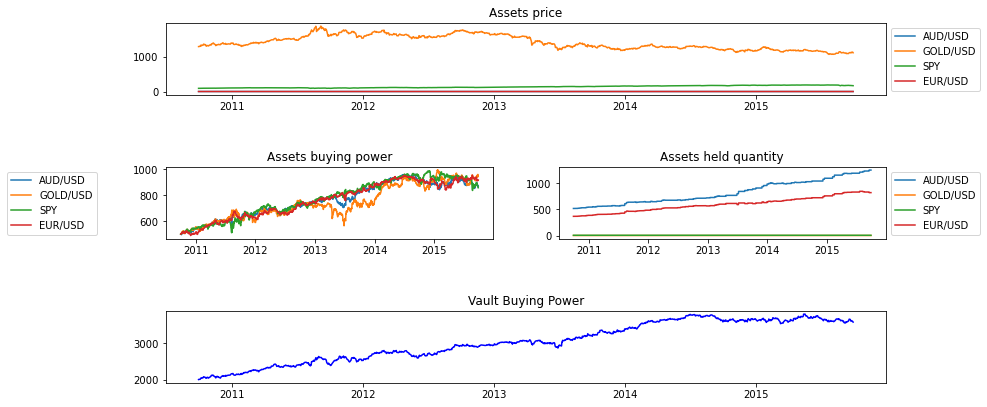

In [26]:
## USD and GOLD with a 50-50 ratio and slippage of 5% and 7 day rebalance interval
simulation_logs = simulate_multiple_assets_vault(
    multiple_assets_df_list,
    [0.25] * 4,
    starting_buying_power=2000,
    slippage=0.05,
    sell_apr_percentage=0.1,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

plot_multiple_assets_results(simulation_logs)

Start with vault as below:
{'asset_1': 484.15000000000003,
 'asset_1_buying_power': 500.0,
 'asset_1_name': 'AUD/USD',
 'asset_2': 652390.0,
 'asset_2_buying_power': 500.0,
 'asset_2_name': 'GOLD/USD',
 'asset_3': 46719.2115,
 'asset_3_buying_power': 500.0,
 'asset_3_name': 'SPY',
 'asset_4': 682.4,
 'asset_4_buying_power': 500.0,
 'asset_4_name': 'EUR/USD',
 'vault_buying_power': 2000}

Finished with 97 rebalances
Final buying power of the vault is 4302

Ending with vault as below:
{'asset_1': 768.0074810380419,
 'asset_1_buying_power': 1102.9836005142063,
 'asset_1_name': 'AUD/USD',
 'asset_2': 1197703.8650459107,
 'asset_2_buying_power': 1064.5310328378907,
 'asset_2_name': 'GOLD/USD',
 'asset_3': 186921.86866479693,
 'asset_3_buying_power': 1096.2226473780693,
 'asset_3_name': 'SPY',
 'asset_4': 1189.1571030092389,
 'asset_4_buying_power': 1061.3683532749365,
 'asset_4_name': 'EUR/USD',
 'vault_buying_power': 4302.234879213767}


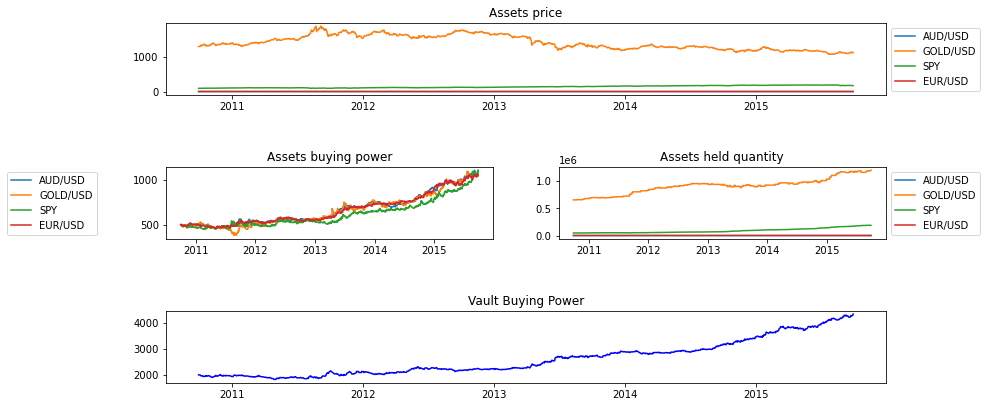

In [27]:
## USD and GOLD with a 50-50 ratio and slippage of 5% and 7 day rebalance interval
simulation_logs = simulate_multiple_assets_vault_test(
    multiple_assets_df_list,
    [0.25] * 4,
    starting_buying_power=2000,
    slippage=0.05,
    sell_apr_percentage=0.1,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

plot_multiple_assets_results(simulation_logs)

### More conditions: 
Status: TODO

In [ ]:
## USD and GOLD with a 50-50 ratio and slippage of 5% and 7 day rebalance interval
results, config = simulate_model(
    df,
    ratio_a=0.5,
    ratio_b=0.5, 
    starting_buying_power=2000,
    slippage=0.01,
    sell_apr_percentage=0.1,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

In [ ]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 1 day rebalance interval; but selling 50% of 
# the appreciated side instead of 1%
results, config = simulate_model(
    df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=1,
    sell_apr_percentage=0.5
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

In [ ]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 1 day rebalance interval; but selling 50% of 
# the appreciated side instead of 1%
results, config = simulate_model(
    df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=1,
    sell_apr_percentage=0.5
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

# eventually we run out of one side of asset because we sell too much; 
# so we should ideally avoid this scenario..

In [ ]:
# USD and GOLD with a 50-50 ratio with no rebalancing
results, config = simulate_model(
    df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    sell_apr_percentage=0
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

In [ ]:
## USD and GOLD with a 50-50 ratio and slippage of 5% and 7 day rebalance interval
results, config = simulate_model_test(
    df,
    ratio_a=0.5,
    ratio_b=0.5, 
    starting_buying_power=2000,
    slippage=0.01,
    sell_apr_percentage=0.1,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

### Artificial Data Simulations:
Status: TODO

In [ ]:
# With one appreciating asset and one depreciating asset. The net result is on the positive.
results, config = simulate_model(
    appreciating_asset,
    depreciating_asset,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT
)

plot_results(results)

In [ ]:
# With two depreciating assets. Really nothing we can do here. the
# net loss in the vault is the averaged loss; Which shows the importance of
# choosing two assets that are hedges of each other...

results, config = simulate_model(
    depreciating_asset,
    depreciating_asset,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT
)

plot_results(results)